## LOAD


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Reshape, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from joblib import Parallel, delayed  # 🔥 For multiprocessing

In [ ]:
# Enable mixed precision (Faster Training)
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Define paths and parameters
DATASET_PATH = "path"
NUM_CLASSES = 2
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 64  # 🔥 Reduced for speed
MAX_TIME_STEPS = 109

In [ ]:
# Ensure dataset folders exist
for class_name in ["real", "fake"]:
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_path):
        raise FileNotFoundError(f"Missing folder: {class_path}")

# Audio augmentation function
def augment_audio(audio, sr=SAMPLE_RATE):
    rate = np.random.uniform(0.9, 1.1)
    audio = librosa.effects.time_stretch(audio, rate=rate)
    n_steps = np.random.randint(-3, 3)
    audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    noise_amplitude = np.random.uniform(0.001, 0.005)
    noise = np.random.randn(len(audio)) * noise_amplitude
    return audio + noise

# Function to process a single file
def process_file(file_path, label):
    try:
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if np.random.rand() > 0.5:
            audio = augment_audio(audio)

        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Ensure fixed size
        if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

        return mel_spectrogram, label
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

In [ ]:
# Load dataset using multiprocessing
X, y = [], []
all_files = []

for label, class_name in enumerate(["real", "fake"]):
    class_path = os.path.join(DATASET_PATH, class_name)
    all_files.extend([(os.path.join(class_path, f), label) for f in os.listdir(class_path) if f.endswith(('.mp3', '.wav'))])

results = Parallel(n_jobs=-1)(delayed(process_file)(fp, lbl) for fp, lbl in all_files)

# Filter out None values
X, y = zip(*[res for res in results if res is not None])

In [ ]:
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
import numpy as np

# Save features and labels
np.save('X.npy', X)
np.save('y.npy', y)

In [1]:
import numpy as np

# Load the preprocessed data
X = np.load('X.npy')
y = np.load('y.npy')
NUM_CLASSES = 2

# Ensure y is one-hot encoded
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, NUM_CLASSES)

In [2]:
from sklearn.model_selection import train_test_split

# First split: 80% training, 20% temporary (for validation and testing)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 10% validation, 10% testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes to verify the splits
print(f"Training data: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation data: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Testing data: X_test={X_test.shape}, y_test={y_test.shape}")

Training data: X_train=(139399, 64, 109), y_train=(139399, 2)
Validation data: X_val=(17425, 64, 109), y_val=(17425, 2)
Testing data: X_test=(17425, 64, 109), y_test=(17425, 2)


In [7]:
from tensorflow.keras.layers import Input
# Fix CNN input shape
input_shape = (X_train.shape[1], X_train.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_val = X_val.reshape(X_val.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)
# Define the model (same as before)
model_input = Input(shape=input_shape)

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Reshape((x.shape[1], -1))(x)
x = TimeDistributed(Dense(64))(x)

x = LSTM(64, return_sequences=False)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=model_input, outputs=model_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y, axis=1)), y=np.argmax(y, axis=1))
class_weights = dict(enumerate(class_weights))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/20
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 1023s 232ms/step - accuracy: 0.8253 - loss: 0.6373 - val_accuracy: 0.8855 - val_loss: 0.3631 - learning_rate: 0.0010
Epoch 2/20
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 1005s 231ms/step - accuracy: 0.9457 - loss: 0.1528 - val_accuracy: 0.8611 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 3/20
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 899s 206ms/step - accuracy: 0.9526 - loss: 0.1360 - val_accuracy: 0.9189 - val_loss: 0.2149 - learning_rate: 0.0010
Epoch 4/20
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 740s 170ms/step - accuracy: 0.9586 - loss: 0.1212 - val_accuracy: 0.8929 - val_loss: 0.2829 - learning_rate: 0.0010
Epoch 5/20
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 725s 166ms/step - accuracy: 0.9613 - loss: 0.1137 - val_accuracy: 0.9481 - val_loss: 0.1557 - learning_rate: 0.0010
Epoch 6/20
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 715s 164ms/step - accuracy: 0.9575 - loss: 0.1227 - val_accuracy: 0.8900 - val_loss: 0.2899 - learning_rate: 0.0010
Epoch 7/20
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 717s 165

In [9]:
# saving the model
model.save("TESTSETAaudio_classifier.keras")

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

545/545 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9865 - loss: 0.0420
Test Loss: 0.040972039103507996
Test Accuracy: 0.986513614654541


In [17]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


545/545 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step
Confusion Matrix:
[[8787  110]
 [ 125 8403]]


In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


545/545 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9865 - loss: 0.0420
Test Loss: 0.0410
Test Accuracy: 0.9865


In [13]:
# Get predictions
y_pred_probs = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class labels


545/545 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step


In [14]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9860    0.9876    0.9868      8897
           1     0.9871    0.9853    0.9862      8528

    accuracy                         0.9865     17425
   macro avg     0.9865    0.9865    0.9865     17425
weighted avg     0.9865    0.9865    0.9865     17425



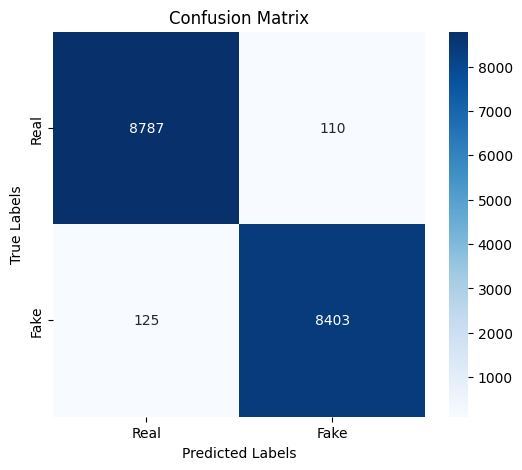

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names (adjust based on your dataset)
class_names = ["Real", "Fake"]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with correct labels
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

